# Introduction

Here I create a set of differentially-accessible peaks for various cell types and conditions. 

**Note**: To run this notebook properly, you must move this notebook to the volume (`mountpoint + 'amo/atac/archR/DA_peaks_run/'`) that has sufficient storage to support the intermediate files in the `tmp/` and `ArchRLogs/` folders that are generated by running. 

# Setup

In [2]:
suppressMessages(library("ArchR"))

In [3]:
set.seed(1)

In [4]:
suppressMessages(addArchRGenome("hg38"))

Be careful with running the following command, see below.

In [5]:
prefix_archR <- '/data/clue/amo/atac/archR/'

In [6]:
ArrowFile <- paste(prefix_archR, 'clue.aggr.concat_2_bcs.arrow', sep='')

At this point, I've realized that for exporting the ArchR project, setting multiple threads kills my kernel no matter how many threads I have it set to. Therefore, I recommend killing the kernel and then re-running without setting multiple threads.

In [7]:
proj <- ArchRProject(
    ArrowFiles = ArrowFile,
    outputDirectory = paste(prefix_archR, 'DA_peaks/', sep=''),
    copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ __

# Add Labels

Here I'll add the lables from the Scanpy analysis. When importing into archR, I've noticed the cells get re-ordered or rearranges, so I'll first export them to get them in the same order as my `h5ad` object in Scanpy, then export the cell labels in that order from Scanpy.

In [8]:
write(getCellNames(proj), paste(prefix_archR, 'vals/cell_names.tsv', sep=''))

Export labels in `atac_enrich.ipynb`. Then come back here and re-import.

In [9]:
ct_labels <- readLines(paste(prefix_archR, 'vals/ct2.txt', sep=''))
cond_labels <- readLines(paste(prefix_archR, 'vals/cond.txt', sep=''))

In [10]:
proj <- addCellColData(ArchRProj = proj, data = paste0(ct_labels), name = "ct", cells=proj$cellNames)
proj <- addCellColData(ArchRProj = proj, data = paste0(cond_labels), name = "cond", cells=proj$cellNames)

In [11]:
head(getCellColData(proj, select = "ct"), 10)

DataFrame with 10 rows and 1 column
                                                   ct
                                          <character>
clue.aggr.concat_2_bcs#CCGAAGCGTTACCACA-5          cM
clue.aggr.concat_2_bcs#AAATGAGGTACGCAAG-5    T4_Naive
clue.aggr.concat_2_bcs#TGCCTGTTCCTCATTA-4      T4_Mem
clue.aggr.concat_2_bcs#AGATAGACAACTTGGT-3      T4_Mem
clue.aggr.concat_2_bcs#CCAGATAAGGAAGAAC-5    T4_Naive
clue.aggr.concat_2_bcs#TCTCAGCCAGCAACAG-1      T4_Mem
clue.aggr.concat_2_bcs#TTCGTTAGTGCATCAT-5     B_cells
clue.aggr.concat_2_bcs#ACCCAAAGTATTCGAC-4         cDC
clue.aggr.concat_2_bcs#CGTGGCAAGTACCTCA-2      T4_Mem
clue.aggr.concat_2_bcs#CAATCCCCAAACTACC-5         ncM

# Control

## Run Peak Calling using MACS2

Create new objects...

In [39]:
idxSample <- BiocGenerics::which((proj$ct %in% c("T4_Naive", "NK", "B_cells", "cM")) & (proj$cond %in% "C"))
cellsSample <- proj$cellNames[idxSample]
proj_enrich <- proj[cellsSample, ]

In [40]:
pathToMacs2 <- '/home/ssm-user/miniconda3/envs/archR_R/bin/macs2'

In [ ]:
proj_enrich <- addGroupCoverages(
    ArchRProj = proj_enrich,
    groupBy = "ct"
)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-5b099349a6-Date-2022-07-21_Time-23-27-16.log
If there is an issue, please report to github with logFile!

B_cells (1 of 4) : CellGroups N = 2

cM (2 of 4) : CellGroups N = 2

NK (3 of 4) : CellGroups N = 2

T4_Naive (4 of 4) : CellGroups N = 2

2022-07-21 23:27:16 : Creating Coverage Files!, 0.008 mins elapsed.

2022-07-21 23:27:16 : Batch Execution w/ safelapply!, 0.008 mins elapsed.

2022-07-21 23:27:16 : Group B_cells._.Rep1 (1 of 8) : Creating Group Coverage File : B_cells._.Rep1.insertions.coverage.h5, 0.008 mins elapsed.

Number of Cells = 500

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames

2022-07-21 23:27:47 : Group B_cells._.Rep2 (2 of 8) : Creating Group Coverage File : B_cells._.Rep2.insertions.coverage.h5, 0.518 mins elapsed.

Number of Cells = 40

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added Arro

In [ ]:
print(1)

In [42]:
proj_enrich <- addReproduciblePeakSet(
    ArchRProj = proj_enrich, 
    groupBy = "ct",
    peakmethod='Macs2',
    pathToMacs2 = pathToMacs2
)

2022-07-21 23:35:43 : Group 2 of 8, Calling Peaks with MACS2!, 1.826 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B_cells._.Rep2-2 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B_cells._.Rep2-2.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-21 23:36:15 : Group 3 of 8, Calling Peaks with MACS2!, 2.346 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name cM._.Rep1-3 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/cM._.Rep1-3.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-21 23:38:36 : Group 4 of 8, Calling Peaks with MACS2!, 4.707 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name cM.

[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/B_cells-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/NK-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/T4_Naive-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/cM-reproduciblePeaks.gr.rds"


2022-07-21 23:43:31 : Creating Union Peak Set!, 9.624 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-07-21 23:43:34 : Finished Creating Union Peak Set (80871)!, 9.677 mins elapsed.



In [43]:
# saveArchRProject(proj_enrich, outputDirectory = paste(prefix_archR, 'DA_peaks/proj_enrich/', sep=''))
# proj_enrich <- loadArchRProject(paste(prefix_archR, 'DA_peaks/proj_enrich/proj_enrich', sep=''))

In [44]:
proj_enrich <- addPeakMatrix(proj_enrich)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-5b0959a6b6a3-Date-2022-07-21_Time-23-43-34.log
If there is an issue, please report to github with logFile!

2022-07-21 23:43:34 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-07-21 23:44:25 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (1 of 23)!, 0.007 mins elapsed.

2022-07-21 23:44:27 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (2 of 23)!, 0.037 mins elapsed.

2022-07-21 23:44:30 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (3 of 23)!, 0.091 mins elapsed.

2022-07-21 23:44:34 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (4 of 23)!, 0.146 mins elapsed.

2022-07

In [45]:
# saveArchRProject(proj_Control, outputDirectory = '/data/codec/pilot.amo.oct19/atac/archR_outs/control/')
# proj_Control <- loadArchRProject('/data/codec/pilot.amo.oct19/atac/archR_outs/control/')

## Identify Marker Peaks
See [here](https://www.archrproject.com/bookdown/identifying-marker-peaks-with-archr-1.html).

In [46]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = proj_enrich, 
    useMatrix = "PeakMatrix", 
    groupBy = "ct",
    useGroups = c('T4_Naive', 'NK', 'B_cells', 'cM')
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-5b096a6fe890-Date-2022-07-21_Time-23-45-35.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2022-07-21 23:45:35 : Matching Known Biases, 0.002 mins elapsed.

2022-07-21 23:45:37 : Computing Pairwise Tests (1 of 4), 0.029 mins elapsed.

2022-07-21 23:45:55 : Computing Pairwise Tests (2 of 4), 0.323 mins elapsed.

2022-07-21 23:46:12 : Computing Pairwise Tests (3 of 4), 0.617 mins elapsed.

2022-07-21 23:46:30 : Computing Pairwise Tests (4 of 4), 0.912 mins elapsed.

###########
2022-07-21 23:46:48 : Completed Pairwise Tests, 1.21 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-5b096a6fe890-Date-2022-07-21_Time-23-45-35.log



In [47]:
print(1)

[1] 1



Warning message:
"Removed 24 rows containing missing values (geom_point)."


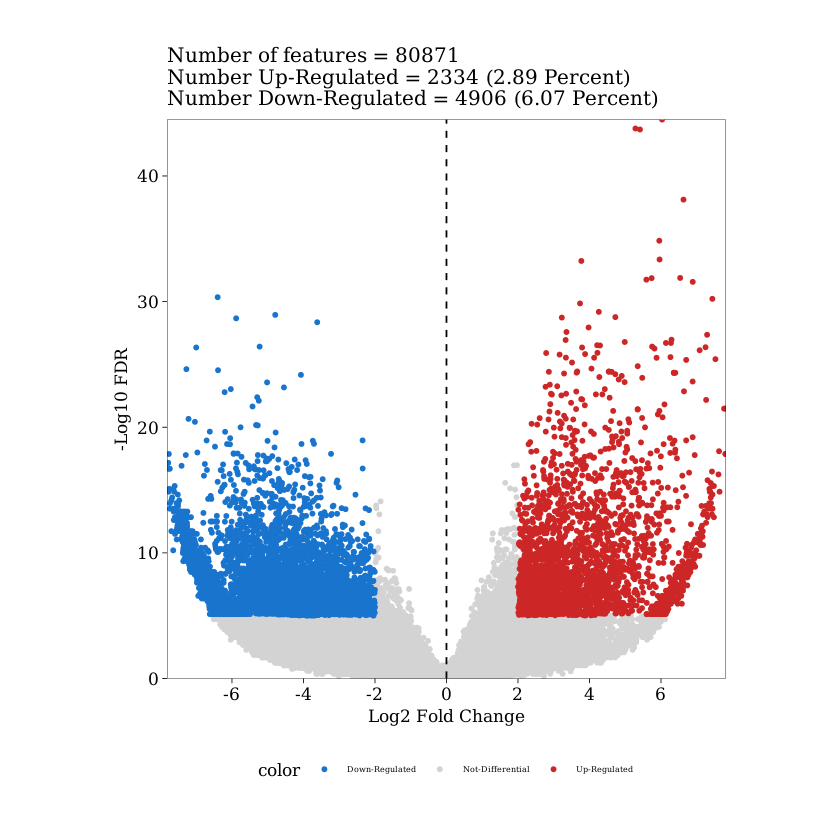

In [48]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "T4_Naive",
    cutOff = "FDR <= 0.00001 & abs(Log2FC) >= 2",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 27 rows containing missing values (geom_point)."


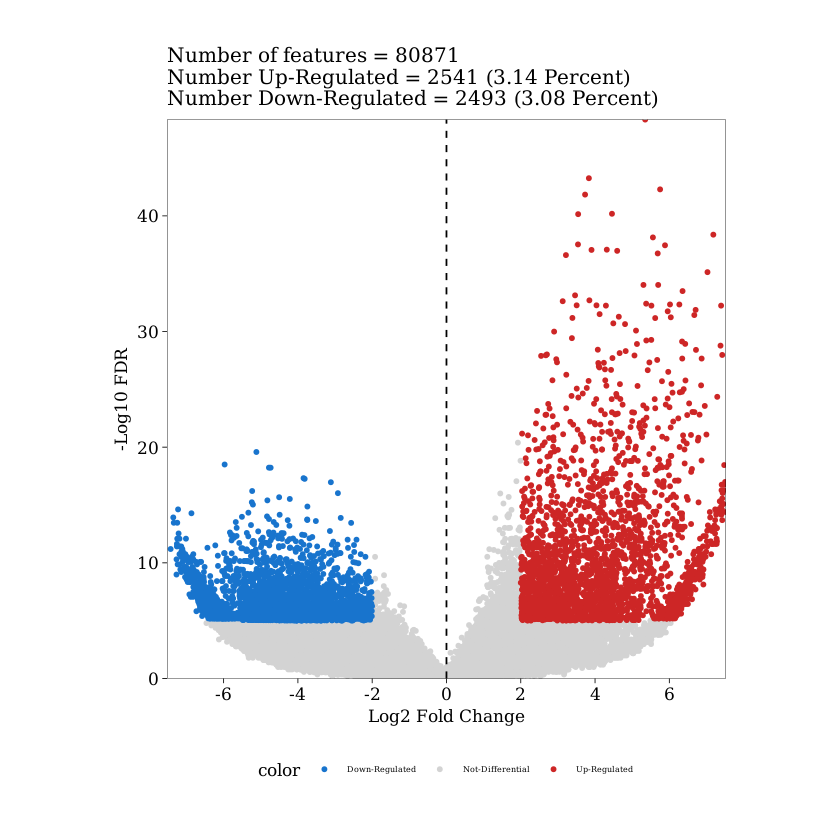

In [49]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "NK",
    cutOff = "FDR <= 0.00001 & abs(Log2FC) >= 2",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 30 rows containing missing values (geom_point)."


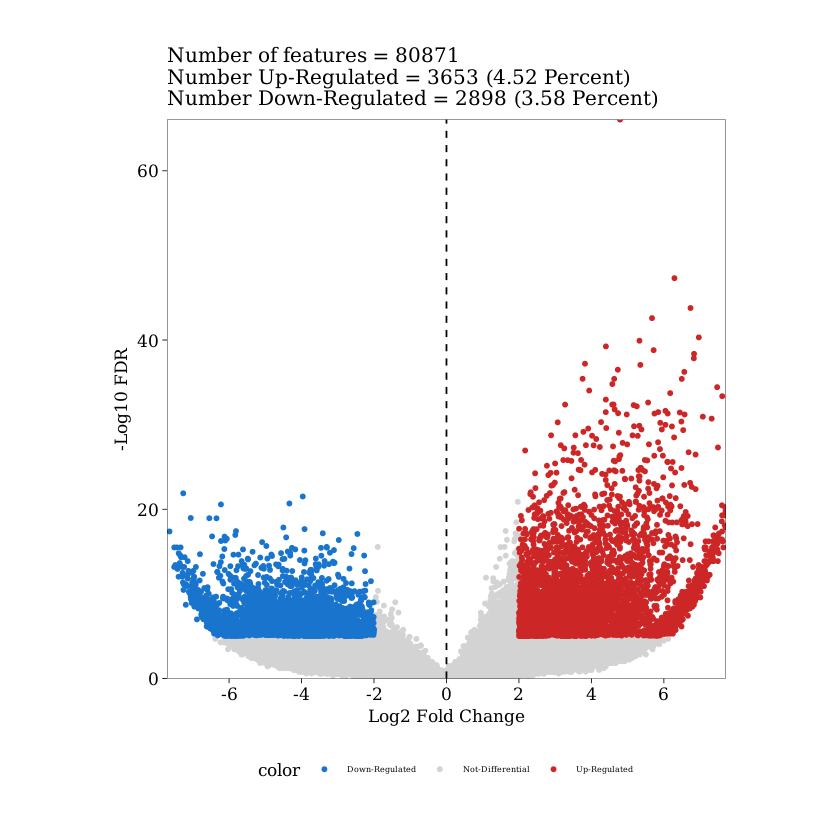

In [50]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "B_cells",
    cutOff = "FDR <= 0.00001 & abs(Log2FC) >= 2",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 22 rows containing missing values (geom_point)."


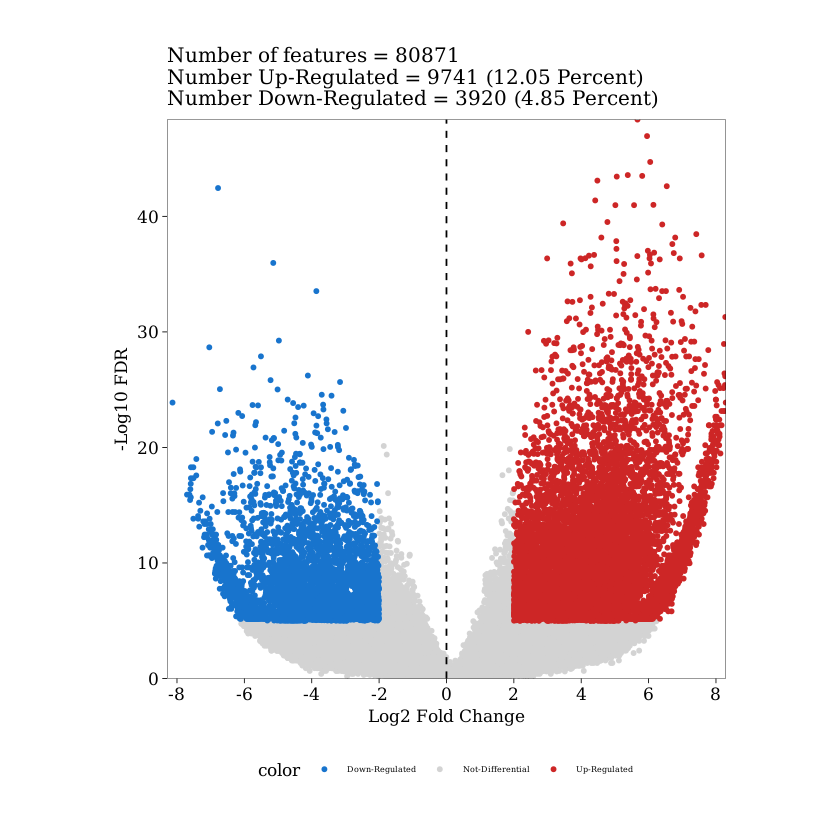

In [51]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "cM",
    cutOff = "FDR <= 0.00001 & abs(Log2FC) >= 2",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers

In [52]:
dir.create(paste(prefix_archR, 'DA_peaks/peaks/', sep=''))

In [53]:
my_assays <- assays(markersPeaks)
write.table(rowData(markersPeaks), paste(prefix_archR, 'DA_peaks/peaks/peaks.tsv', sep=''),  row.names = FALSE, sep='\t', quote = FALSE)
for (my_assay in names(my_assays)){
    write.table(my_assays[[my_assay]], paste(prefix_archR, 'DA_peaks/peaks/', my_assay, '.tsv', sep=''), row.names = FALSE, sep='\t', quote = FALSE)
}

# By `ct`, `cond`-specific

In [26]:
dir.create(paste(prefix_archR, 'DA_peaks/peaks/by_cond/', sep=''))

## `T4_Naive`

### Run Peak Calling using MACS2

Create new objects...

In [13]:
idxSample <- BiocGenerics::which((proj$ct %in% c("T4_Naive")) & (proj$cond %in% c("C", "B", "G")))
cellsSample <- proj$cellNames[idxSample]
proj_enrich <- proj[cellsSample, ]

In [14]:
pathToMacs2 <- '/home/ssm-user/miniconda3/envs/archR_R/bin/macs2'

In [15]:
proj_enrich <- addGroupCoverages(
    ArchRProj = proj_enrich,
    groupBy = "cond"
)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-148355d13668-Date-2022-07-28_Time-13-07-42.log
If there is an issue, please report to github with logFile!

B (1 of 3) : CellGroups N = 2

C (2 of 3) : CellGroups N = 2

G (3 of 3) : CellGroups N = 2

2022-07-28 13:07:42 : Creating Coverage Files!, 0.007 mins elapsed.

2022-07-28 13:07:42 : Batch Execution w/ safelapply!, 0.007 mins elapsed.

2022-07-28 13:07:42 : Group B._.Rep1 (1 of 6) : Creating Group Coverage File : B._.Rep1.insertions.coverage.h5, 0.007 mins elapsed.

Number of Cells = 500

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames

2022-07-28 13:08:23 : Group B._.Rep2 (2 of 6) : Creating Group Coverage File : B._.Rep2.insertions.coverage.h5, 0.689 mins elapsed.

Number of Cells = 40

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames


In [16]:
print(1)

[1] 1


In [17]:
proj_enrich <- addReproduciblePeakSet(
    ArchRProj = proj_enrich, 
    groupBy = "cond",
    peakmethod='Macs2',
    pathToMacs2 = pathToMacs2
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-148330428c19-Date-2022-07-28_Time-13-12-58.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-07-28 13:12:59 : Peak Calling Parameters!, 0.002 mins elapsed.



  Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
B     B   2073        540           2   40  500   150000
C     C   1752        540           2   40  500   150000
G     G   2228        540           2   40  500   150000


2022-07-28 13:12:59 : Batching Peak Calls!, 0.003 mins elapsed.

2022-07-28 13:12:59 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-07-28 13:12:59 : Group 1 of 6, Calling Peaks with MACS2!, 0 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B._.Rep1-1 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B._.Rep1-1.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-28 13:14:52 : Group 2 of 6, Calling Peaks with MACS2!, 1.886 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B._.Rep2-2 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B._.Rep2-2.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-28 13:15:18 : Group 3 

[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/B-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/C-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/G-reproduciblePeaks.gr.rds"


2022-07-28 13:19:47 : Creating Union Peak Set!, 6.803 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-07-28 13:19:50 : Finished Creating Union Peak Set (47396)!, 6.854 mins elapsed.



In [18]:
# saveArchRProject(proj_enrich, outputDirectory = paste(prefix_archR, 'DA_peaks/proj_enrich/', sep=''))
# proj_enrich <- loadArchRProject(paste(prefix_archR, 'DA_peaks/proj_enrich/proj_enrich', sep=''))

In [19]:
proj_enrich <- addPeakMatrix(proj_enrich)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-1483273cf81c-Date-2022-07-28_Time-13-19-50.log
If there is an issue, please report to github with logFile!

2022-07-28 13:19:50 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-07-28 13:20:26 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (1 of 23)!, 0.003 mins elapsed.

2022-07-28 13:20:27 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (2 of 23)!, 0.031 mins elapsed.

2022-07-28 13:20:31 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (3 of 23)!, 0.092 mins elapsed.

2022-07-28 13:20:35 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (4 of 23)!, 0.161 mins elapsed.

2022-07

In [20]:
# saveArchRProject(proj_Control, outputDirectory = '/data/codec/pilot.amo.oct19/atac/archR_outs/control/')
# proj_Control <- loadArchRProject('/data/codec/pilot.amo.oct19/atac/archR_outs/control/')

### Identify Marker Peaks
See [here](https://www.archrproject.com/bookdown/identifying-marker-peaks-with-archr-1.html).

In [21]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = proj_enrich, 
    useMatrix = "PeakMatrix", 
    groupBy = "cond",
    useGroups = c('C', 'B', 'G')
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-14832e19a734-Date-2022-07-28_Time-13-21-39.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2022-07-28 13:21:39 : Matching Known Biases, 0.001 mins elapsed.

2022-07-28 13:21:41 : Computing Pairwise Tests (1 of 3), 0.019 mins elapsed.

2022-07-28 13:21:56 : Computing Pairwise Tests (2 of 3), 0.282 mins elapsed.

2022-07-28 13:22:12 : Computing Pairwise Tests (3 of 3), 0.541 mins elapsed.

###########
2022-07-28 13:22:27 : Completed Pairwise Tests, 0.8 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-14832e19a734-Date-2022-07-28_Time-13-21-39.log



In [22]:
print(1)

[1] 1



Warning message:
"Removed 14 rows containing missing values (geom_point)."


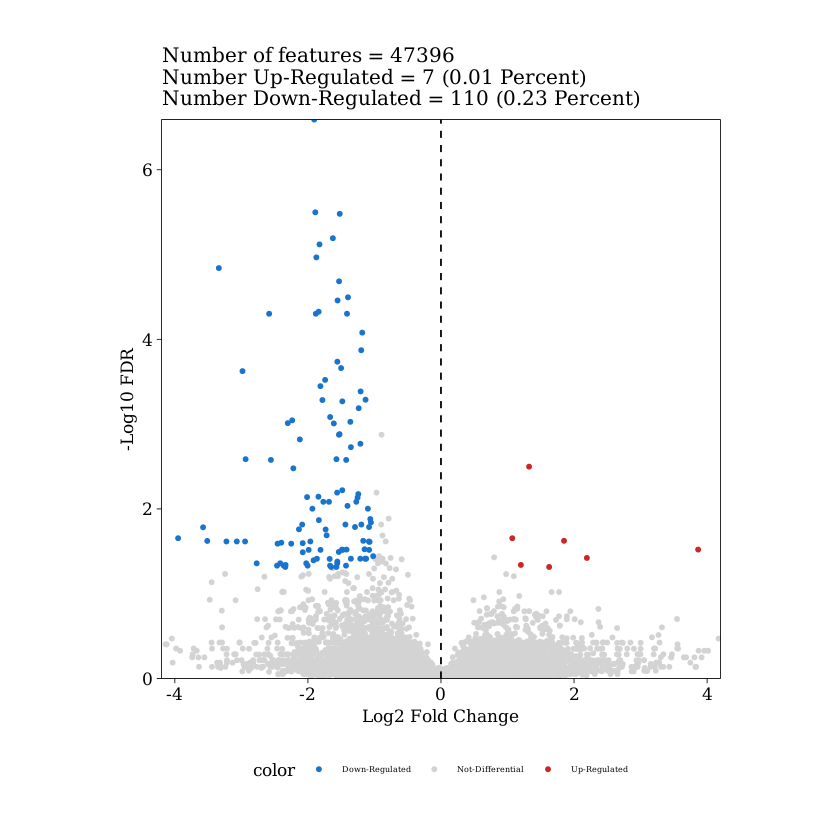

In [34]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "C",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 5 rows containing missing values (geom_point)."


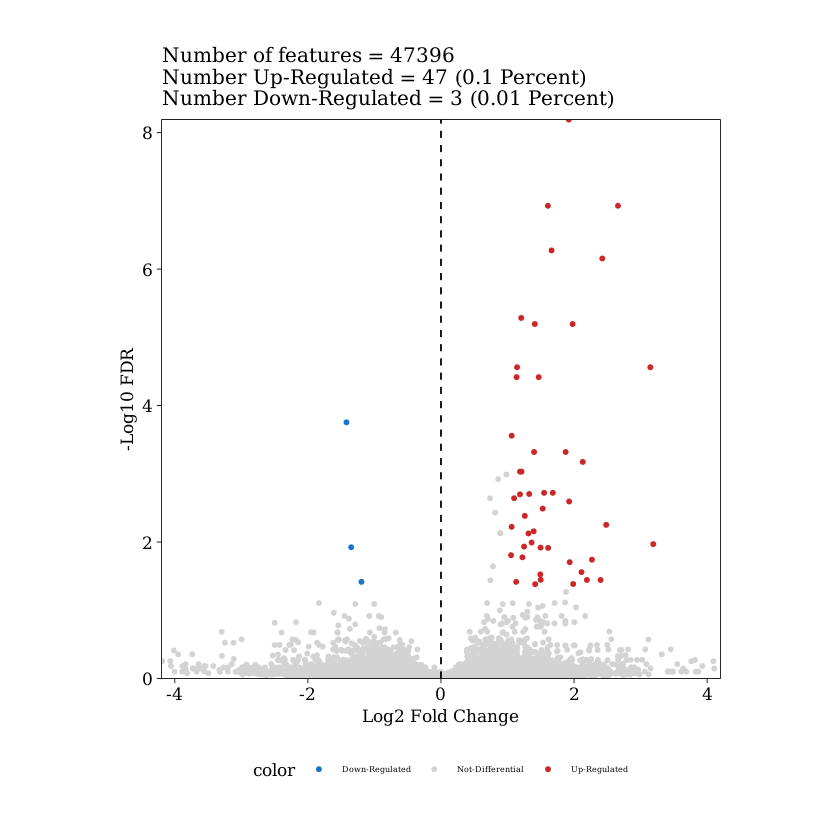

In [35]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "B",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 8 rows containing missing values (geom_point)."


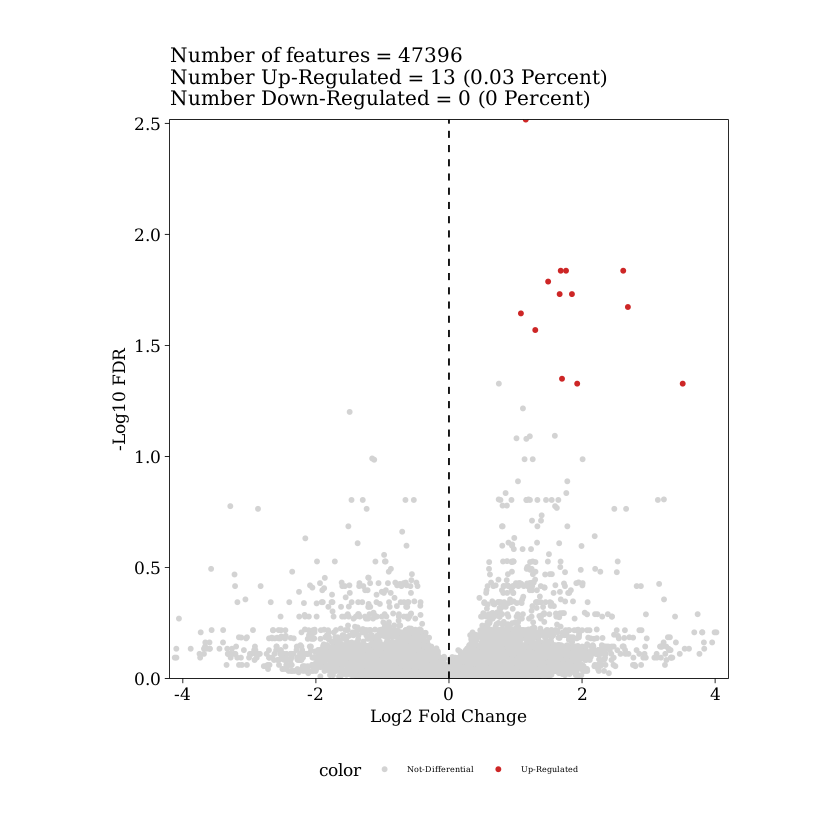

In [36]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "G",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers

In [37]:
dir.create(paste(prefix_archR, 'DA_peaks/peaks/by_cond/T4_Naive', sep=''))

In [38]:
my_assays <- assays(markersPeaks)
write.table(rowData(markersPeaks), paste(prefix_archR, 'DA_peaks/peaks/by_cond/T4_Naive/peaks.tsv', sep=''),  row.names = FALSE, sep='\t', quote = FALSE)
for (my_assay in names(my_assays)){
    write.table(my_assays[[my_assay]], paste(prefix_archR, 'DA_peaks/peaks/by_cond/T4_Naive/', my_assay, '.tsv', sep=''), row.names = FALSE, sep='\t', quote = FALSE)
}

## `B_cells`

### Run Peak Calling using MACS2

Create new objects...

In [39]:
idxSample <- BiocGenerics::which((proj$ct %in% c("B_cells")) & (proj$cond %in% c("C", "B", "G")))
cellsSample <- proj$cellNames[idxSample]
proj_enrich <- proj[cellsSample, ]

In [40]:
pathToMacs2 <- '/home/ssm-user/miniconda3/envs/archR_R/bin/macs2'

In [41]:
proj_enrich <- addGroupCoverages(
    ArchRProj = proj_enrich,
    groupBy = "cond"
)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-148336f376b1-Date-2022-07-28_Time-13-27-37.log
If there is an issue, please report to github with logFile!

B (1 of 3) : CellGroups N = 2

C (2 of 3) : CellGroups N = 2

G (3 of 3) : CellGroups N = 2

2022-07-28 13:27:37 : Creating Coverage Files!, 0.006 mins elapsed.

2022-07-28 13:27:37 : Batch Execution w/ safelapply!, 0.006 mins elapsed.

2022-07-28 13:27:37 : Group B._.Rep1 (1 of 6) : Creating Group Coverage File : B._.Rep1.insertions.coverage.h5, 0.006 mins elapsed.

Number of Cells = 500

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames

2022-07-28 13:28:09 : Group B._.Rep2 (2 of 6) : Creating Group Coverage File : B._.Rep2.insertions.coverage.h5, 0.544 mins elapsed.

Number of Cells = 40

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames


In [42]:
print(1)

[1] 1


In [43]:
proj_enrich <- addReproduciblePeakSet(
    ArchRProj = proj_enrich, 
    groupBy = "cond",
    peakmethod='Macs2',
    pathToMacs2 = pathToMacs2
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-148319a8b66f-Date-2022-07-28_Time-13-32-36.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-07-28 13:32:36 : Peak Calling Parameters!, 0.003 mins elapsed.



  Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
B     B   1252        540           2   40  500   150000
C     C   1100        540           2   40  500   150000
G     G   1163        540           2   40  500   150000


2022-07-28 13:32:36 : Batching Peak Calls!, 0.003 mins elapsed.

2022-07-28 13:32:36 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-07-28 13:32:36 : Group 1 of 6, Calling Peaks with MACS2!, 0 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B._.Rep1-1 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B._.Rep1-1.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-28 13:34:23 : Group 2 of 6, Calling Peaks with MACS2!, 1.781 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B._.Rep2-2 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B._.Rep2-2.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-28 13:34:53 : Group 3 

[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/B-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/C-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/G-reproduciblePeaks.gr.rds"


2022-07-28 13:39:40 : Creating Union Peak Set!, 7.063 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-07-28 13:39:43 : Finished Creating Union Peak Set (54779)!, 7.113 mins elapsed.



In [44]:
# saveArchRProject(proj_enrich, outputDirectory = paste(prefix_archR, 'DA_peaks/proj_enrich/', sep=''))
# proj_enrich <- loadArchRProject(paste(prefix_archR, 'DA_peaks/proj_enrich/proj_enrich', sep=''))

In [45]:
proj_enrich <- addPeakMatrix(proj_enrich)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-148335331e61-Date-2022-07-28_Time-13-39-43.log
If there is an issue, please report to github with logFile!

2022-07-28 13:39:43 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-07-28 13:40:01 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (1 of 23)!, 0.003 mins elapsed.

2022-07-28 13:40:02 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (2 of 23)!, 0.028 mins elapsed.

2022-07-28 13:40:05 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (3 of 23)!, 0.073 mins elapsed.

2022-07-28 13:40:08 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (4 of 23)!, 0.128 mins elapsed.

2022-07

In [46]:
# saveArchRProject(proj_Control, outputDirectory = '/data/codec/pilot.amo.oct19/atac/archR_outs/control/')
# proj_Control <- loadArchRProject('/data/codec/pilot.amo.oct19/atac/archR_outs/control/')

### Identify Marker Peaks
See [here](https://www.archrproject.com/bookdown/identifying-marker-peaks-with-archr-1.html).

In [47]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = proj_enrich, 
    useMatrix = "PeakMatrix", 
    groupBy = "cond",
    useGroups = c('C', 'B', 'G')
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-148363d885df-Date-2022-07-28_Time-13-41-02.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2022-07-28 13:41:02 : Matching Known Biases, 0.001 mins elapsed.

2022-07-28 13:41:02 : Computing Pairwise Tests (1 of 3), 0.012 mins elapsed.

2022-07-28 13:41:18 : Computing Pairwise Tests (2 of 3), 0.279 mins elapsed.

2022-07-28 13:41:34 : Computing Pairwise Tests (3 of 3), 0.544 mins elapsed.

###########
2022-07-28 13:41:50 : Completed Pairwise Tests, 0.808 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-148363d885df-Date-2022-07-28_Time-13-41-02.log



In [48]:
print(1)

[1] 1



Warning message:
"Removed 15 rows containing missing values (geom_point)."


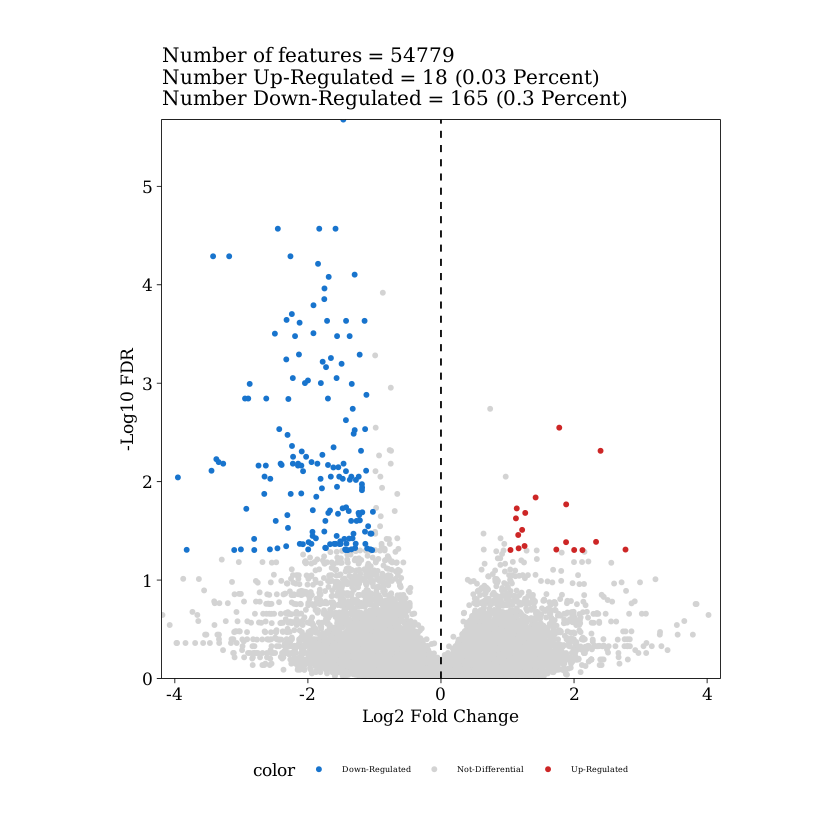

In [49]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "C",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 8 rows containing missing values (geom_point)."


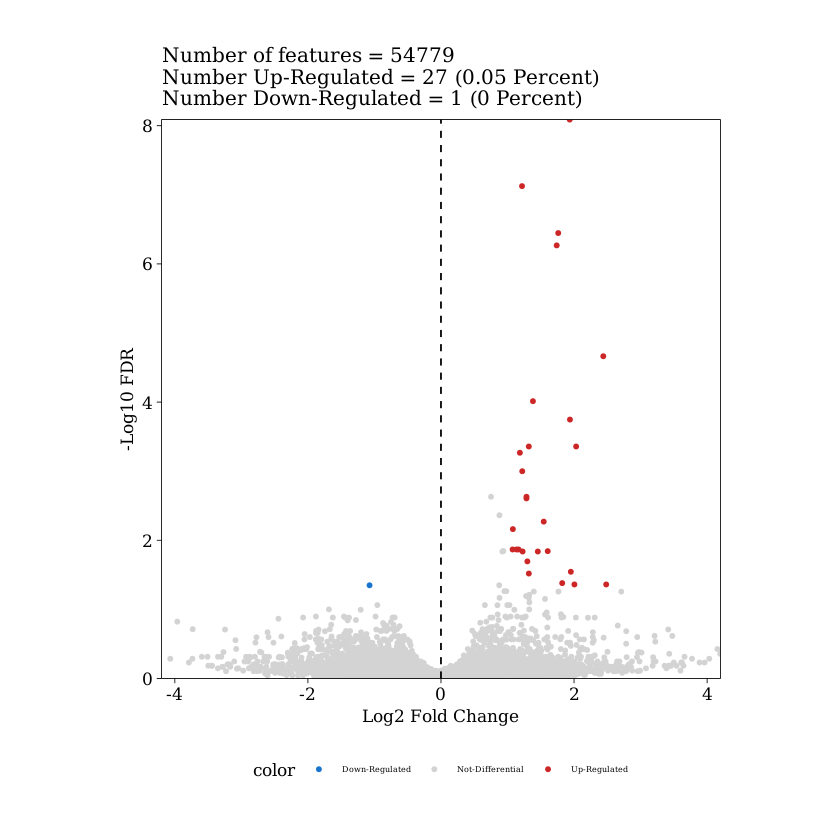

In [50]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "B",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 8 rows containing missing values (geom_point)."


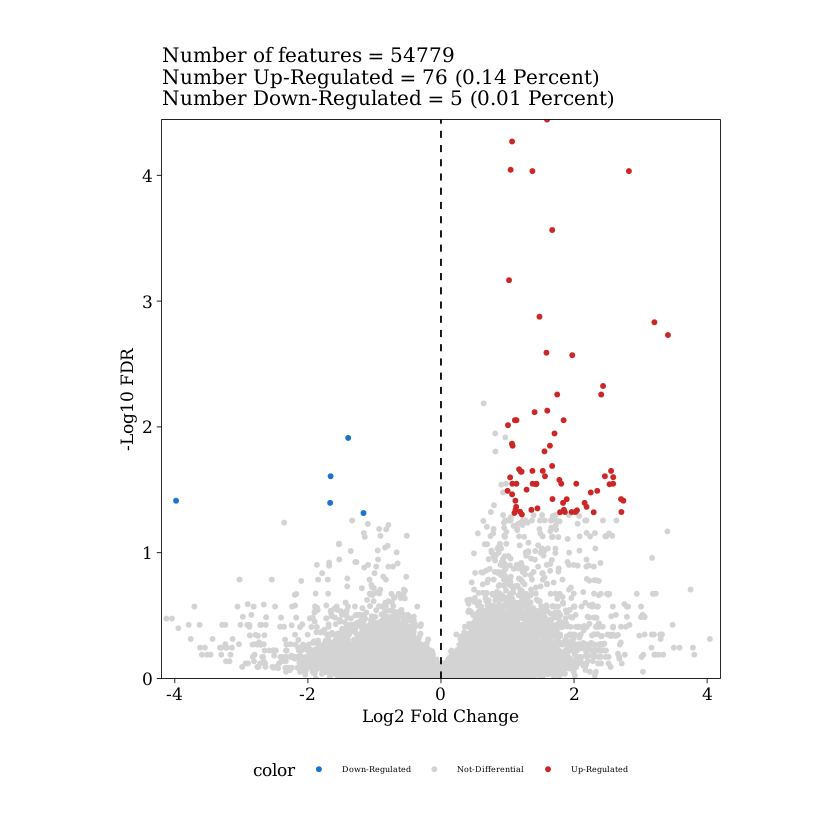

In [51]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "G",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers

In [52]:
dir.create(paste(prefix_archR, 'DA_peaks/peaks/by_cond/B_cells', sep=''))

In [53]:
my_assays <- assays(markersPeaks)
write.table(rowData(markersPeaks), paste(prefix_archR, 'DA_peaks/peaks/by_cond/B_cells/peaks.tsv', sep=''),  row.names = FALSE, sep='\t', quote = FALSE)
for (my_assay in names(my_assays)){
    write.table(my_assays[[my_assay]], paste(prefix_archR, 'DA_peaks/peaks/by_cond/B_cells/', my_assay, '.tsv', sep=''), row.names = FALSE, sep='\t', quote = FALSE)
}

## `cM`

### Run Peak Calling using MACS2

Create new objects...

In [54]:
idxSample <- BiocGenerics::which((proj$ct %in% c("cM")) & (proj$cond %in% c("C", "B", "G")))
cellsSample <- proj$cellNames[idxSample]
proj_enrich <- proj[cellsSample, ]

In [55]:
pathToMacs2 <- '/home/ssm-user/miniconda3/envs/archR_R/bin/macs2'

In [56]:
proj_enrich <- addGroupCoverages(
    ArchRProj = proj_enrich,
    groupBy = "cond"
)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-14834e8b8f71-Date-2022-07-28_Time-13-42-01.log
If there is an issue, please report to github with logFile!

B (1 of 3) : CellGroups N = 2

C (2 of 3) : CellGroups N = 2

G (3 of 3) : CellGroups N = 2

2022-07-28 13:42:01 : Creating Coverage Files!, 0.006 mins elapsed.

2022-07-28 13:42:01 : Batch Execution w/ safelapply!, 0.006 mins elapsed.

2022-07-28 13:42:01 : Group B._.Rep1 (1 of 6) : Creating Group Coverage File : B._.Rep1.insertions.coverage.h5, 0.006 mins elapsed.

Number of Cells = 500

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames

2022-07-28 13:42:35 : Group B._.Rep2 (2 of 6) : Creating Group Coverage File : B._.Rep2.insertions.coverage.h5, 0.558 mins elapsed.

Number of Cells = 40

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames


In [57]:
print(1)

[1] 1


In [58]:
proj_enrich <- addReproduciblePeakSet(
    ArchRProj = proj_enrich, 
    groupBy = "cond",
    peakmethod='Macs2',
    pathToMacs2 = pathToMacs2
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-1483be314c6-Date-2022-07-28_Time-13-47-13.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-07-28 13:47:13 : Peak Calling Parameters!, 0.003 mins elapsed.



  Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
B     B   1798        540           2   40  500   150000
C     C   1463        540           2   40  500   150000
G     G   1356        540           2   40  500   150000


2022-07-28 13:47:13 : Batching Peak Calls!, 0.003 mins elapsed.

2022-07-28 13:47:13 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-07-28 13:47:13 : Group 1 of 6, Calling Peaks with MACS2!, 0 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B._.Rep1-1 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B._.Rep1-1.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-28 13:49:38 : Group 2 of 6, Calling Peaks with MACS2!, 2.409 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name B._.Rep2-2 --treatment /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds/B._.Rep2-2.insertions.bed --outdir /data/clue/amo/atac/archR/DA_peaks/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2022-07-28 13:50:17 : Group 3 

[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/B-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/C-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/data/clue/amo/atac/archR/DA_peaks/PeakCalls/G-reproduciblePeaks.gr.rds"


2022-07-28 13:56:37 : Creating Union Peak Set!, 9.388 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-07-28 13:56:40 : Finished Creating Union Peak Set (76195)!, 9.44 mins elapsed.



In [59]:
# saveArchRProject(proj_enrich, outputDirectory = paste(prefix_archR, 'DA_peaks/proj_enrich/', sep=''))
# proj_enrich <- loadArchRProject(paste(prefix_archR, 'DA_peaks/proj_enrich/proj_enrich', sep=''))

In [60]:
proj_enrich <- addPeakMatrix(proj_enrich)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-14833acdab96-Date-2022-07-28_Time-13-56-40.log
If there is an issue, please report to github with logFile!

2022-07-28 13:56:40 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-07-28 13:56:58 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (1 of 23)!, 0.007 mins elapsed.

2022-07-28 13:57:00 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (2 of 23)!, 0.034 mins elapsed.

2022-07-28 13:57:04 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (3 of 23)!, 0.108 mins elapsed.

2022-07-28 13:57:07 : Adding clue.aggr.concat_2_bcs to PeakMatrix for Chr (4 of 23)!, 0.164 mins elapsed.

2022-07

In [61]:
# saveArchRProject(proj_Control, outputDirectory = '/data/codec/pilot.amo.oct19/atac/archR_outs/control/')
# proj_Control <- loadArchRProject('/data/codec/pilot.amo.oct19/atac/archR_outs/control/')

### Identify Marker Peaks
See [here](https://www.archrproject.com/bookdown/identifying-marker-peaks-with-archr-1.html).

In [62]:
markersPeaks <- getMarkerFeatures(
    ArchRProj = proj_enrich, 
    useMatrix = "PeakMatrix", 
    groupBy = "cond",
    useGroups = c('C', 'B', 'G')
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-148329267832-Date-2022-07-28_Time-13-58-12.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2022-07-28 13:58:12 : Matching Known Biases, 0.001 mins elapsed.

2022-07-28 13:58:13 : Computing Pairwise Tests (1 of 3), 0.013 mins elapsed.

2022-07-28 13:58:29 : Computing Pairwise Tests (2 of 3), 0.292 mins elapsed.

2022-07-28 13:58:46 : Computing Pairwise Tests (3 of 3), 0.569 mins elapsed.

###########
2022-07-28 13:59:03 : Completed Pairwise Tests, 0.845 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-148329267832-Date-2022-07-28_Time-13-58-12.log



In [63]:
print(1)

[1] 1



Warning message:
"Removed 42 rows containing missing values (geom_point)."


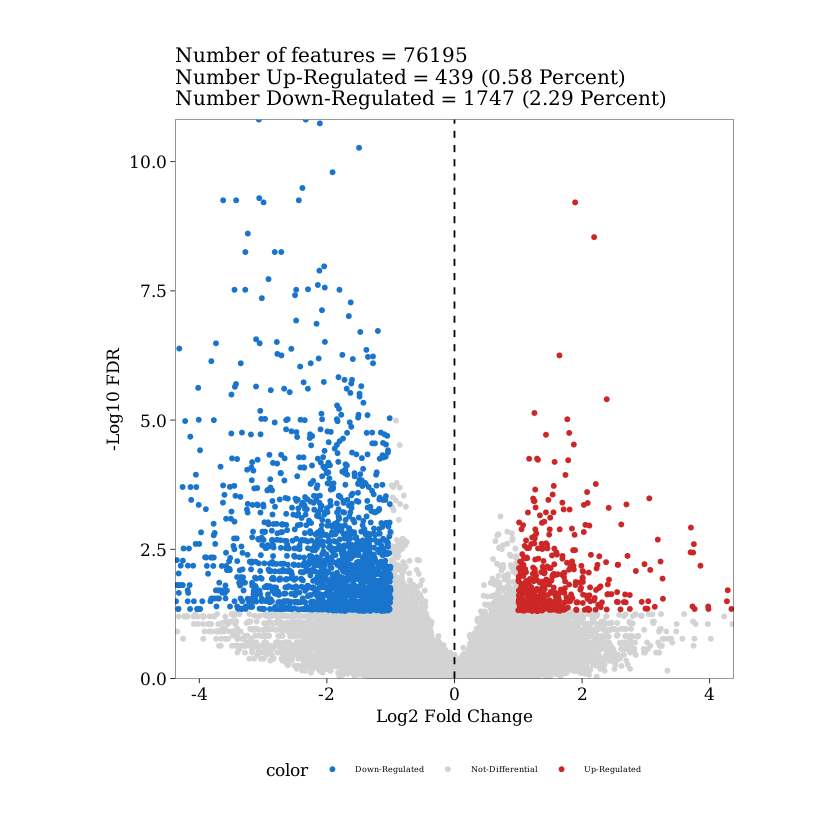

In [64]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "C",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 9 rows containing missing values (geom_point)."


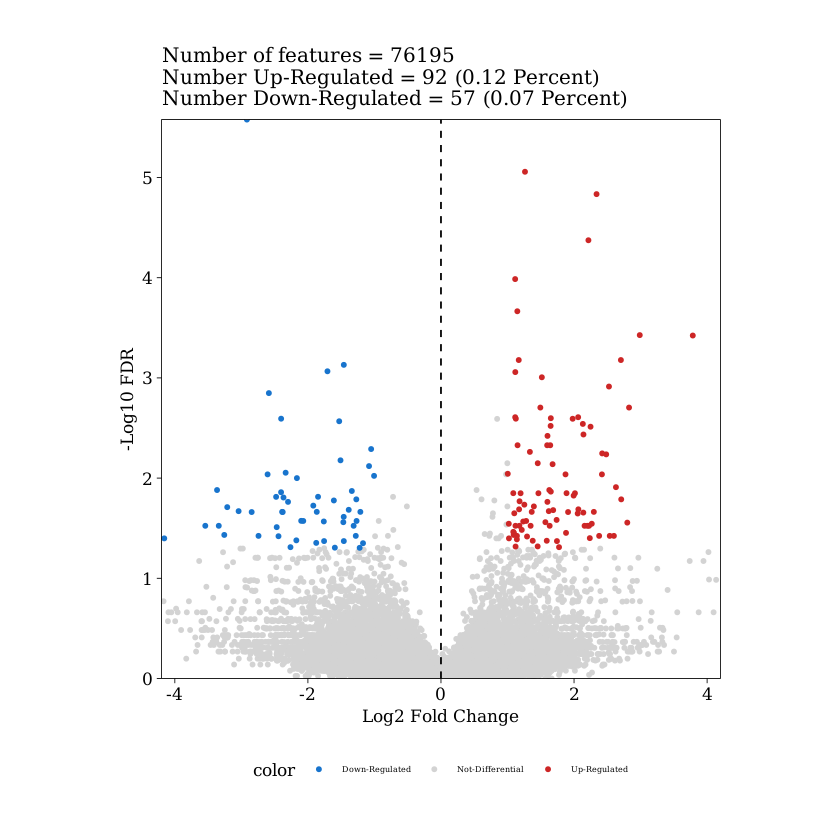

In [65]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "B",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers


Warning message:
"Removed 53 rows containing missing values (geom_point)."


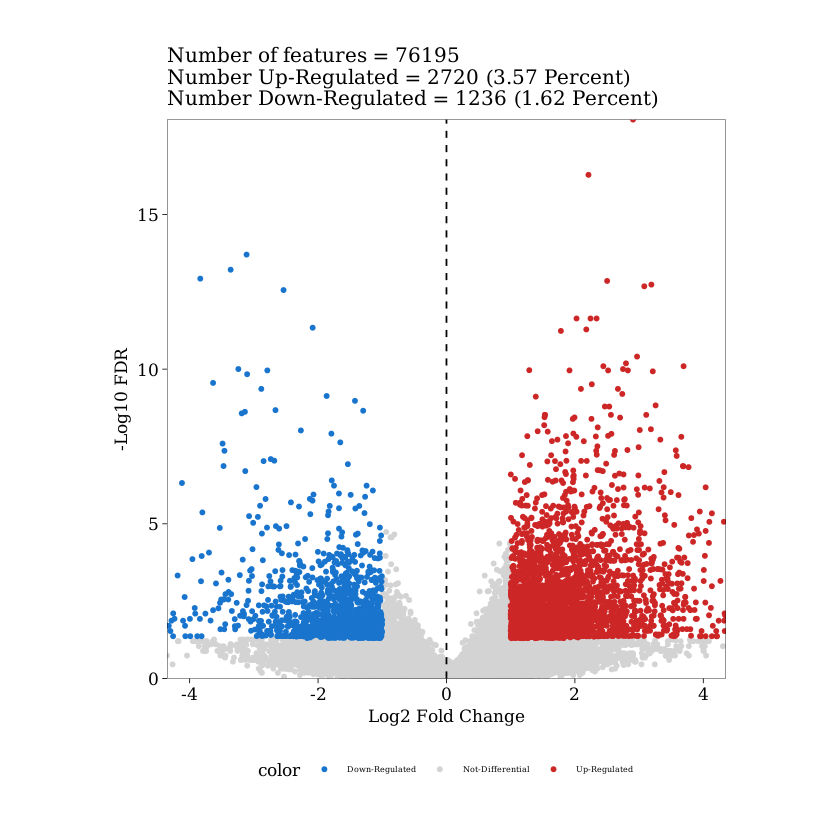

In [66]:
markers <- plotMarkers(
    seMarker = markersPeaks,
    name = "G",
    cutOff = "FDR <= 0.05 & abs(Log2FC) >= 1",
    plotAs = "Volcano",
    scaleTo = 10^4
)
markers

In [67]:
dir.create(paste(prefix_archR, 'DA_peaks/peaks/by_cond/cM', sep=''))

In [68]:
my_assays <- assays(markersPeaks)
write.table(rowData(markersPeaks), paste(prefix_archR, 'DA_peaks/peaks/by_cond/cM/peaks.tsv', sep=''),  row.names = FALSE, sep='\t', quote = FALSE)
for (my_assay in names(my_assays)){
    write.table(my_assays[[my_assay]], paste(prefix_archR, 'DA_peaks/peaks/by_cond/cM/', my_assay, '.tsv', sep=''), row.names = FALSE, sep='\t', quote = FALSE)
}